In [1]:
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
from kdd_oh_set import ohkdd
from cnn_model import CNet

In [2]:
%%time
use_gpu = torch.cuda.is_available()
train_data = ohkdd(test_size=0, use_gpu=use_gpu, data_path='final_train.npy', tar_path='kdd99_oh_5_label.npy',
                   return_type=2)
# valid_data = train_data.get_valid()
test_data = ohkdd(test_size=0, use_gpu=use_gpu, data_path='final_test.npy', tar_path='kdd99_oh_5_label_corrected.npy',
                  return_type=2)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
# valid_loader = DataLoader(valid_data, batch_size=100, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=200, shuffle=True, drop_last=True)

print("use_gpu:{}".format(use_gpu))

use_gpu:True
Wall time: 46.8 s


In [3]:
net = CNet()
loss_func = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-4)

In [4]:
def accuracy(net, input_loader):
    tp = tn = fp = fn = 0
    for x, y in input_loader:
        batch_x = Variable(x)
        batch_y = Variable(y)
        out = net(batch_x)
        res = torch.max(out, 1)[1]

        for i in range(0, len(batch_y)):
            if res[i] == batch_y[i]:
                if res[i] == 1:
                    tp += 1
                else:
                    tn += 1
            else:
                if batch_y[i] == 1:
                    fp += 1
                else:
                    fn += 1
    ac = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return [ac, precision, recall, f1]

In [5]:
%%time
loss_count = []
acc_count = []
if use_gpu:
    net = net.cuda()
    loss_func = loss_func.cuda()
print("training start...")
for epoch in range(5):
    for i, (x, y) in enumerate(train_loader):
        batch_x = Variable(x)
        batch_y = Variable(y)

        out = net(batch_x)  #模型输出
        loss = loss_func(out, batch_y)  #损失计算

        opt.zero_grad()  #消除旧值
        loss.backward()  #回传
        opt.step()  #更新模型参数

        if i % 10000 == 0:  #打点输出
            # loss_count.append(loss)
            print("{}th{}:\t".format(epoch + 1, i), loss.item())
            acc = accuracy(net, test_loader)
            acc_count.append(acc)
            print("acc:\t{}\nprecision:\t{}\nrecal:\t{}\nF1:\t{}".format(*acc))

    torch.save(net, r'kdd_cnn')  #存储模型

training start...
1th0:	 0.6746222376823425
acc:	0.1995209003215434
precision:	0.014659723497887498
recal:	0.6246384209630764
F1:	0.028647123777268805
1th10000:	 0.0033406075090169907
acc:	0.9347588424437299
precision:	0.9236264745581317
recal:	0.9949882557409208
F1:	0.957980234763952
1th20000:	 0.0007103564566932619
acc:	0.9340353697749196
precision:	0.9225878848142868
recal:	0.9951326251949104
F1:	0.9574881209189943
1th30000:	 0.0011499951360747218
acc:	0.9330192926045016
precision:	0.9211898790792773
recal:	0.9952712352172168
F1:	0.9567987390731773
1th40000:	 0.07800094038248062
acc:	0.9324147909967846
precision:	0.9204554076665349
recal:	0.9952503087299326
F1:	0.9563927494828914
2th0:	 0.00038258859422057867
acc:	0.9343858520900321
precision:	0.922918721621654
recal:	0.9952457442089806
F1:	0.9577186381116564
2th10000:	 0.0017049494199454784
acc:	0.9315209003215434
precision:	0.9193299123455064
recal:	0.9952617699191562
F1:	0.9557901292231044
2th20000:	 0.006595544051378965
acc:	0.9

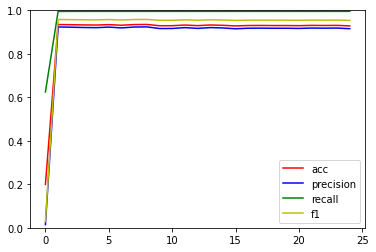

In [6]:
plt.figure('cnn_acc')
acc_count = list(map(list, zip(*acc_count)))
plt.plot(acc_count[0], 'r', label='acc')
plt.plot(acc_count[1], 'b', label='precision')
plt.plot(acc_count[2], 'g', label='recall')
plt.plot(acc_count[3], 'y', label='f1')
plt.legend()
plt.ylim(0, 1.0)
plt.show()

In [7]:
%%time
acc = accuracy(net, test_loader)
acc_count.append(acc)
print("acc:\t{}\nprecision:\t{}\nrecal:\t{}\nF1:\t{}".format(*acc))

if __name__ == '__main__':
    print('model training end...')

acc:	0.9305016077170418
precision:	0.918051379121691
recal:	0.9952680910015802
F1:	0.955101599923556
model training end...
Wall time: 42.4 s
